# Generate heatmaps and scatter plots for *in vitro* data

## Construct heatmaps to enable bacterial metabolomic profile comparisons

This set of heatmaps enables visualization of metabolic profiles of 158 mega-media grown bacterial strains. On the y-axis, taxonomies, or bacterial strains, are clustered by 1) 16S phylogenetic distance, or 2) metabolomic distance (Ward-clustered). On the x-axis, metabolites are Ward-clustered using Euclidean distance between the fold-change (log2 transformed) values across all taxonomies. The *in vitro* metabolite fold-change matrix (log2 transformed) is used to generate these heatmaps. 


In [11]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy import stats
from scipy.spatial.distance import euclidean, squareform

In [12]:
def get_internal_standards_columns(fc_matrix, dname_cpd_map):
    return [
        dname for dname in fc_matrix.columns 
        if dname in dname_cpd_map and dname_cpd_map[dname].startswith('IS_')
    ]

class Heatmap:

    def __init__(self,
                 cpd_library,
                 fc_matrix,
                 aggregated_md,
                 full_taxonomy):
        self.cpd_library = cpd_library
        self.full_taxonomy = full_taxonomy

        # Translate library dnames to compound names by building a dname-to-compound-name map
        dname_cpd_map = cpd_library \
            .groupby(['dname'])['Compound'] \
            .apply(lambda compounds: list(set(compounds.values))) \
            .to_dict()

        dnames_with_multiple_cpds = { dname:cpds for dname, cpds in dname_cpd_map.items() if len(cpds) > 1 }.keys()
        
        # Co-eluting compounds (sharing the same dnames) are concatenated together by their compound names
        dname_cpd_map = cpd_library \
            .groupby(['dname'])['Compound'] \
            .apply(lambda compounds: ', '.join(sorted(set(compounds)))) \
            .to_dict()

        # Remove internal standard columns so they are not displayed as a part the heatmap
        fc_matrix = fc_matrix.drop(columns=get_internal_standards_columns(fc_matrix, dname_cpd_map))

        # Pull in data from aggregated_md so we get metadata information for each biological replicate
        fc_matrix = fc_matrix.join(aggregated_md[['experiment', 'sample_type', 'media', 'taxonomy']], how="left")
        
        fc_matrix = fc_matrix[fc_matrix['sample_type'] == 'supernatant']
                                   
        # Averaging the fold-change values (log2 transformed) among all biological replicates of the same taxonomy
        # Only the mega-media grown bacterial strain data are shown
        self.fc_matrix = fc_matrix[fc_matrix['media'] == 'mm'] \
            .drop(columns=['experiment', 'sample_type', 'media']) \
            .groupby(['taxonomy']) \
            .agg(lambda values: np.log2(np.mean(2 ** values)))

        self.taxonomy_dist_matrix = self._calc_taxonomy_dist_matrix(self.fc_matrix)

        # Remove co-eluting compounds (dnames that are associated w/ multiple compounds)
        # Metabolites that are uniquely detected (non-coeluting) by our methods are displayed
        self.fc_matrix = self.fc_matrix \
            .drop(columns=list(set(self.fc_matrix.columns) & set(dnames_with_multiple_cpds)))

        # Rename metabolite columns in the fold-change matrix using the dname-to-compound-name map above
        self.fc_matrix = self.fc_matrix.rename(columns=dname_cpd_map)

        # Keep only metabolite columns detected in at least 50% of the taxonomies to enable ward-clustering
        VALID_VALUES_THRESHOLD = 0.5

        self.fc_matrix = self.fc_matrix.dropna(axis='columns',
                                     thresh=math.floor(len(self.fc_matrix) * VALID_VALUES_THRESHOLD))


    def _calc_taxonomy_dist_matrix(self, fc_matrix):
        """
        Calculate distance matrix between all taxonomies using the
        Euclidean distance between fold-change values as the distance metric
        """
        
        num_taxonomies = len(fc_matrix)

        dist_matrix = np.zeros((num_taxonomies, num_taxonomies), dtype=float)

        for i in range(num_taxonomies):
            taxonomy_i = fc_matrix.iloc[i]
            nans_i = np.isnan(taxonomy_i.values)

            for j in range(num_taxonomies):
                taxonomy_j = fc_matrix.iloc[j]
                nans_j = np.isnan(taxonomy_j.values)

                combined_nans = nans_i | nans_j

                # Ignore metabolites with at least one missing value in either taxonomy
                taxonomy_i_no_nans = taxonomy_i[~combined_nans]
                taxonomy_j_no_nans = taxonomy_j[~combined_nans]

                dist_matrix[i, j] = euclidean(taxonomy_i_no_nans, taxonomy_j_no_nans)

        return dist_matrix


    def _calc_metabolite_dist_matrix(self):
        """
        Calculate distance matrix between all metabolites using the
        Euclidean distance between fold-change values as the distance metric
        """
        
        num_metabolites = len(self.fc_matrix.columns)

        dist_matrix = np.zeros((num_metabolites, num_metabolites), dtype=float)

        for i in range(num_metabolites):
            metabolite_i = self.fc_matrix.iloc[:,i].values
            nans_i = np.isnan(metabolite_i)

            for j in range(num_metabolites):
                metabolite_j = self.fc_matrix.iloc[:,j].values

                nans_j = np.isnan(metabolite_j)

                combined_nans = nans_i | nans_j

                # Ignore taxonomies with at least one missing value in either metabolite
                metabolite_i_no_nans = metabolite_i[~combined_nans]
                metabolite_j_no_nans = metabolite_j[~combined_nans]

                if len(metabolite_i_no_nans) == 0:
                    dist_matrix[i, j] = 10000
                    continue

                dist_matrix[i, j] = euclidean(metabolite_i_no_nans, metabolite_j_no_nans)

        return dist_matrix


    def get_metabolite_cluster_order(self):
        return self.fc_matrix_cluster_order.columns.values


    def plot(self, taxonomies = None):
        fig = plt.figure(figsize=(30, 40))

        heatmap_left = 0.2
        heatmap_bottom = 0.3
        heatmap_width = 0.75
        heatmap_height = 0.5

        phyla_bar = fig.add_axes([heatmap_left - 0.009, heatmap_bottom, 0.004, heatmap_height])

        metabolite_dendrogram = fig.add_axes([heatmap_left, heatmap_bottom + heatmap_height, heatmap_width, 0.07])
        heatmap = fig.add_axes([heatmap_left, heatmap_bottom, heatmap_width, heatmap_height])
        colorbar = fig.add_axes([heatmap_left + heatmap_width + 0.005, 0.4, 0.008, 0.3])

        metabolite_dist_matrix = self._calc_metabolite_dist_matrix()

        condensed_dist_matrix = squareform(metabolite_dist_matrix)

        linkage_matrix = sch.linkage(condensed_dist_matrix,
                                     method='ward',
                                     optimal_ordering=True)

        Z2 = sch.dendrogram(linkage_matrix,
                            ax=metabolite_dendrogram,
                            truncate_mode=None,
                            orientation='top',
                            color_threshold=0,
                            above_threshold_color='k',
                            labels=self.fc_matrix.columns)

        metabolite_dendrogram.axis('off')

        palette = plt.cm.bwr
        palette.set_bad(color='grey', alpha=0.15)

        # Order the data matrix consistent with the dendrogram leaves
        if taxonomies:
            fc_matrix_cluster_order = self.fc_matrix.loc[taxonomies]
            fc_matrix_cluster_order = fc_matrix_cluster_order.iloc[:, list(Z2['leaves'])]
        else:
            taxonomy_dendrogram = fig.add_axes([0.008, heatmap_bottom, 0.07, heatmap_height])

            # scipy linkage wants the distance matrix in condensed form
            condensed_dist_matrix = squareform(self.taxonomy_dist_matrix)

            linkage_matrix = sch.linkage(condensed_dist_matrix,
                                         method='ward',
                                         optimal_ordering=True)

            Z1 = sch.dendrogram(linkage_matrix,
                                ax=taxonomy_dendrogram,
                                truncate_mode=None,
                                orientation='left',
                                color_threshold=0,
                                above_threshold_color='k')

            taxonomy_dendrogram.axis('off')

            # Order the data matrix consistent with the dendrogram leaves
            # We need to reverse the order because of pcolormesh
            fc_matrix_cluster_order = self.fc_matrix.iloc[list(reversed(Z1['leaves'])), list(Z2['leaves'])]

        # Create a masked array with all nan's masked
        data = np.ma.array(fc_matrix_cluster_order, mask=np.isnan(fc_matrix_cluster_order))

        c = heatmap.pcolormesh(data,
                               cmap=palette,
                               vmin=-4,
                               vmax=4,
                               linewidth=0.5,
                               edgecolors='grey')

        # Create a separate one-column-wide heatmap for color-coding taxonomies by phylum
        phyla = fc_matrix_cluster_order[[]].join(self.full_taxonomy[['phylum']])

        phyla_color_dict = {
            'Bacteroidetes': 0,
            'Firmicutes': 1,
            'Proteobacteria': 2,
            'Actinobacteria': 3,
            'Fusobacteria': 4
        }

        phyla['phylum'] = phyla['phylum'].apply(lambda phylum: phyla_color_dict[phylum]);

        cmap = colors.ListedColormap([
             'tab:blue',
             'tab:orange',
             'tab:purple',
             'tab:green',
             'tab:red',
        ])

        norm = colors.BoundaryNorm(np.linspace(0, 5, 6), cmap.N, clip=True)

        phyla_bar.pcolormesh(phyla.values,
                             cmap=cmap,
                             norm=norm,
                             edgecolors='k')

        phyla_bar.set_xticks([])

        phyla_bar.invert_yaxis()

        phyla_bar.set_yticks(np.arange(0.5, len(fc_matrix_cluster_order.index) + 0.5, 1))
        phyla_bar.set_yticklabels(fc_matrix_cluster_order.index)
        phyla_bar.tick_params(axis='y', labelsize=8)

        heatmap.margins(0)

        fig.colorbar(c, cax=colorbar)
        colorbar.tick_params(labelsize=26)

        heatmap.set_xticks(np.arange(0.5, len(fc_matrix_cluster_order.columns) + 0.5, 1))
        heatmap.set_xticklabels(fc_matrix_cluster_order.columns)
        heatmap.tick_params(axis='x', rotation=90, labelsize=8)

        heatmap.invert_yaxis()

        heatmap.set_yticks([])

        self.fc_matrix_cluster_order = fc_matrix_cluster_order

        return fig


In [13]:
cpd_library = pd.read_excel('input/Supplementary_Table_1_mz-rt_library.xlsx', sheet_name='chemical_info')
fc_matrix = pd.read_excel('input/Supplementary_Table_7.xlsx', sheet_name='foldchange.dmrvf.fa.ps_log2', index_col=0)
aggregated_md = pd.read_excel('input/Supplementary_Table_7.xlsx', sheet_name='aggregated_md', index_col=0)
full_taxonomy = pd.read_excel('input/Supplementary_Table_6.xlsx', index_col=0, sheet_name='full_taxonomy')

with open('input/Taxonomy_order.txt', 'r') as f:
    taxonomies = f.read().split('\n')

heatmap = Heatmap(cpd_library, fc_matrix, aggregated_md, full_taxonomy)

## Heatmap with taxonomies clustered by 16S phylogenetic distance

On the y-axis, phylogenetic distance between individual taxonomies has been computed in a seperate script and a .txt file is provided to list these taxonomies in a specific order corresponding to phylogenetic distance clustering. Individual taxonomies are also colored based their designated phylum.

On the x-axis, metabolites are Ward-clustered using Euclidean distance between the fold-change (log2 transformed) values across all taxonomies.


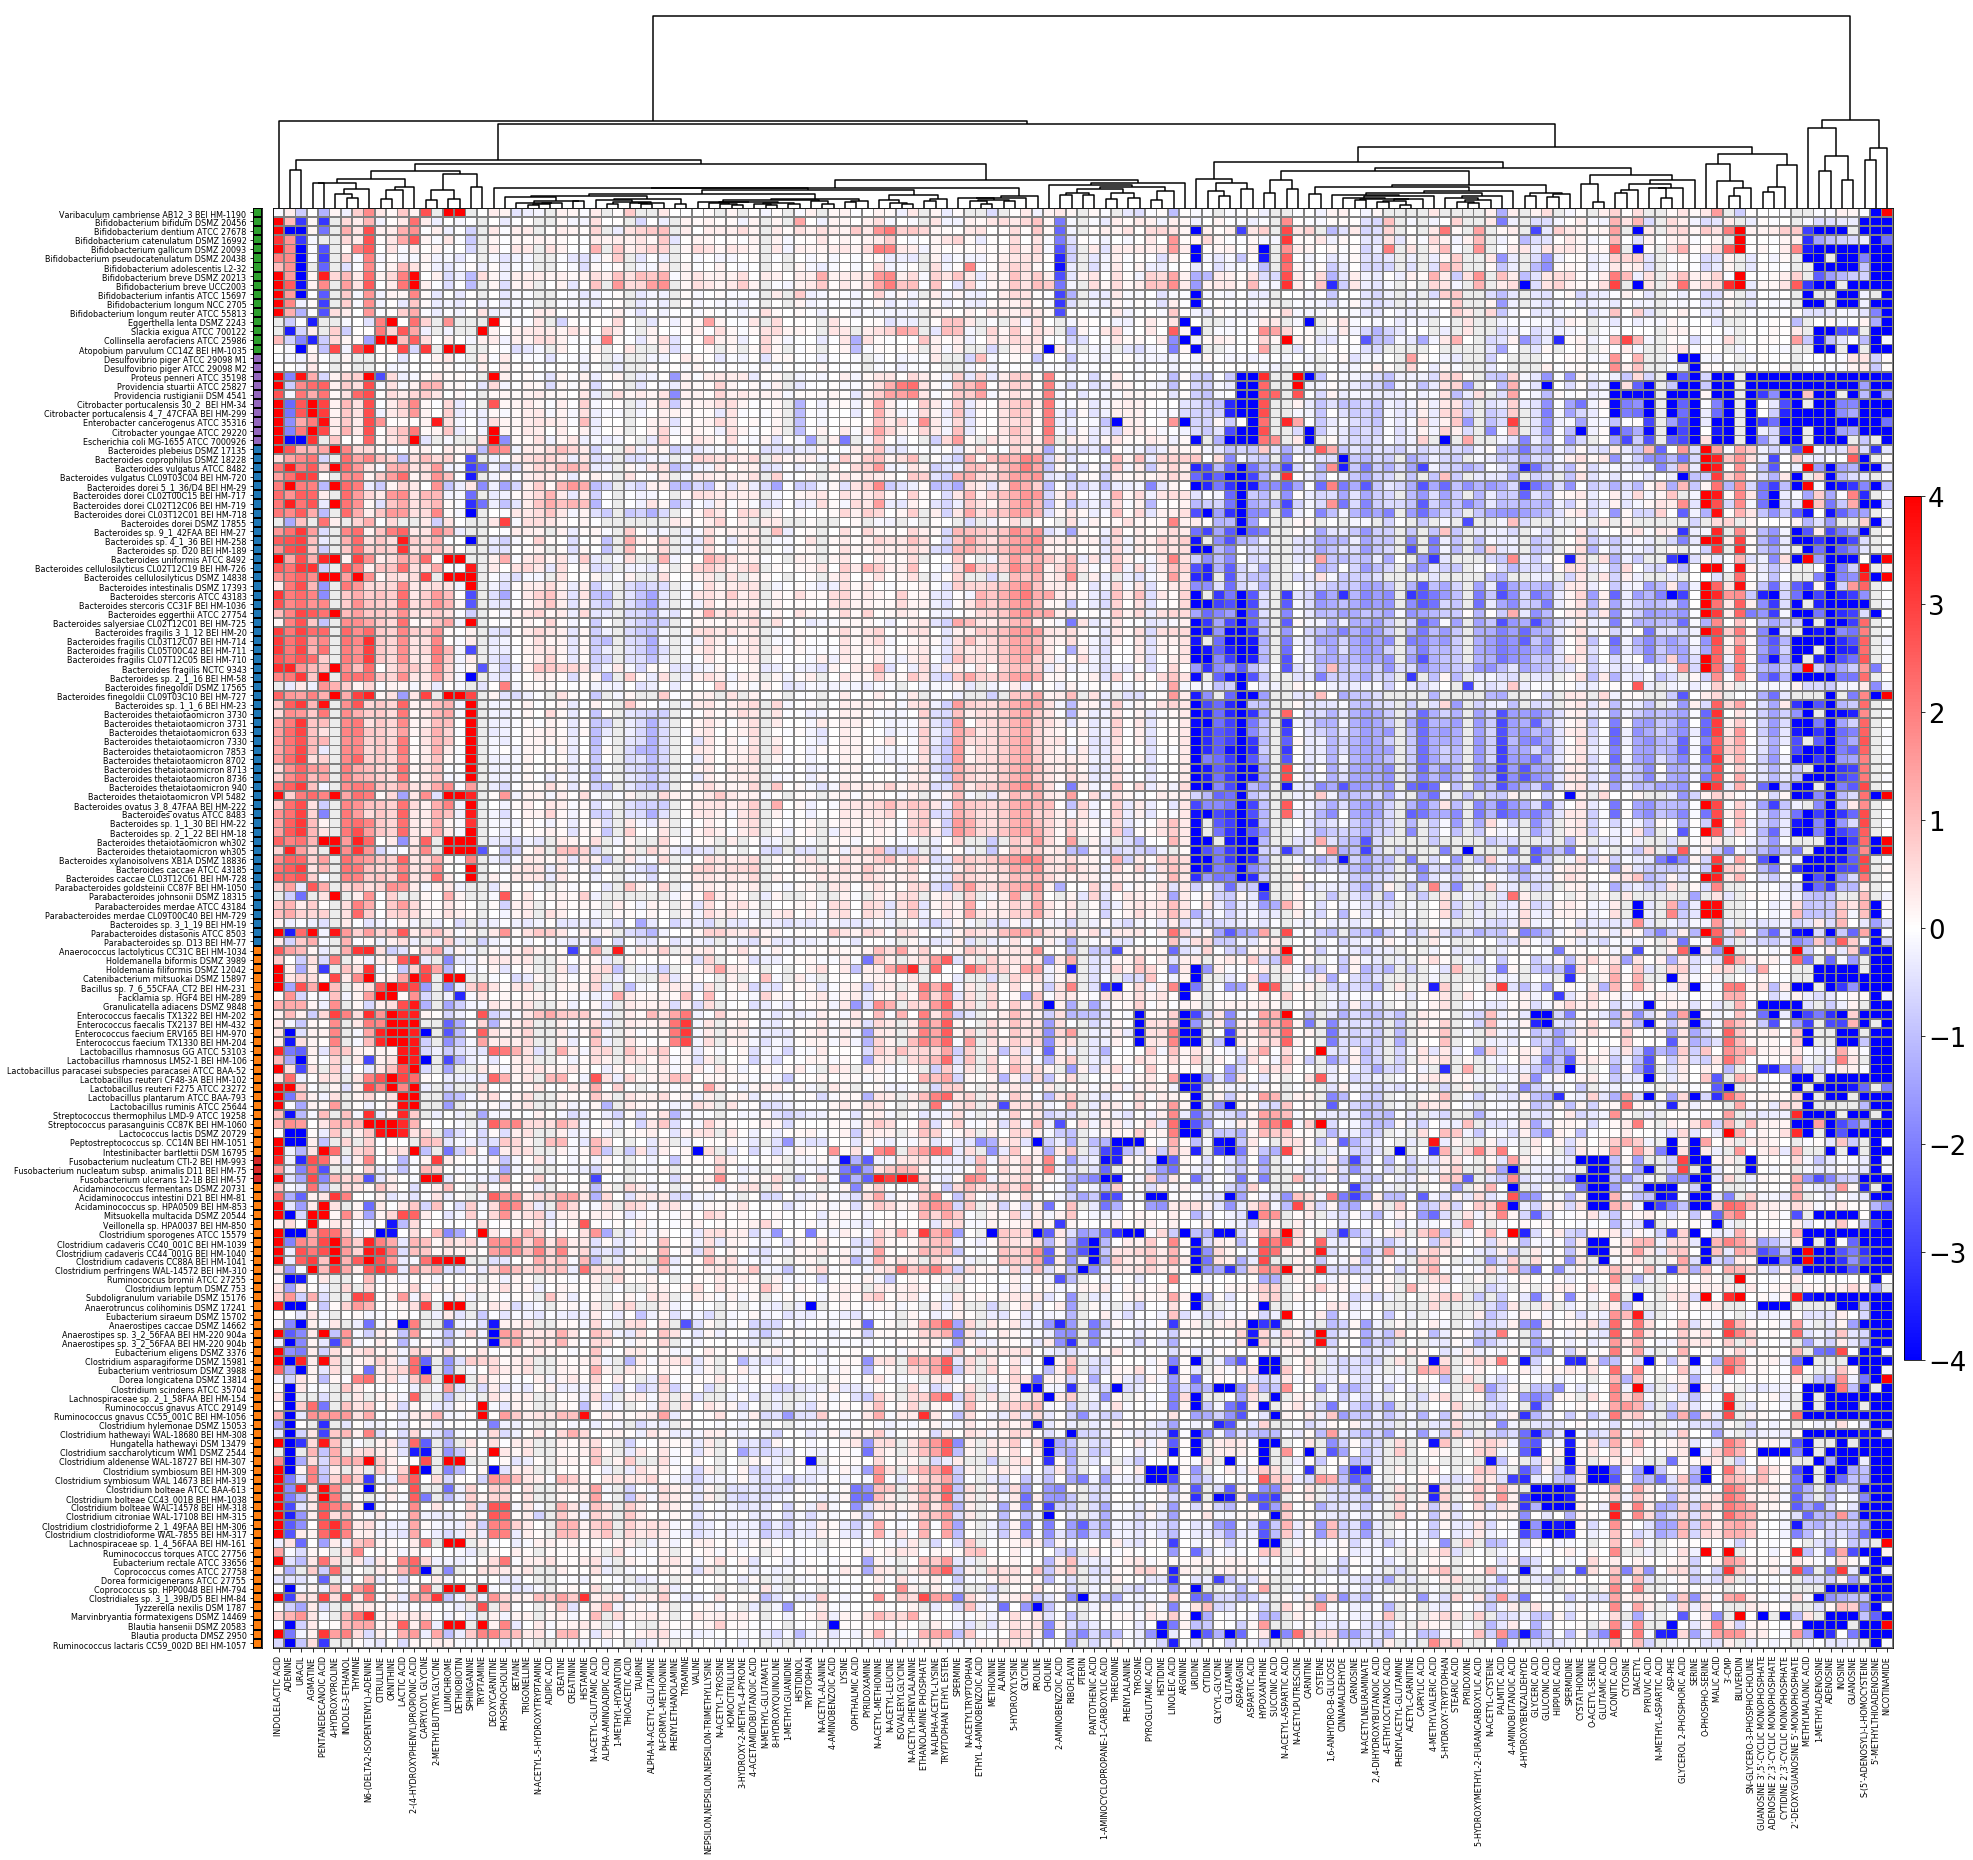

In [14]:
fig = heatmap.plot(taxonomies)

## Heatmap with taxonomies clustered by metabolomic profile distance

On the y-axis, metabolomic profile distance between individual taxonomies is computed and Ward-clustered. Individual taxonomies are also colored based their designated phylum.

On the x-axis, metabolites are Ward-clustered using Euclidean distance between the fold-change (log2 transformed) values across all taxonomies.


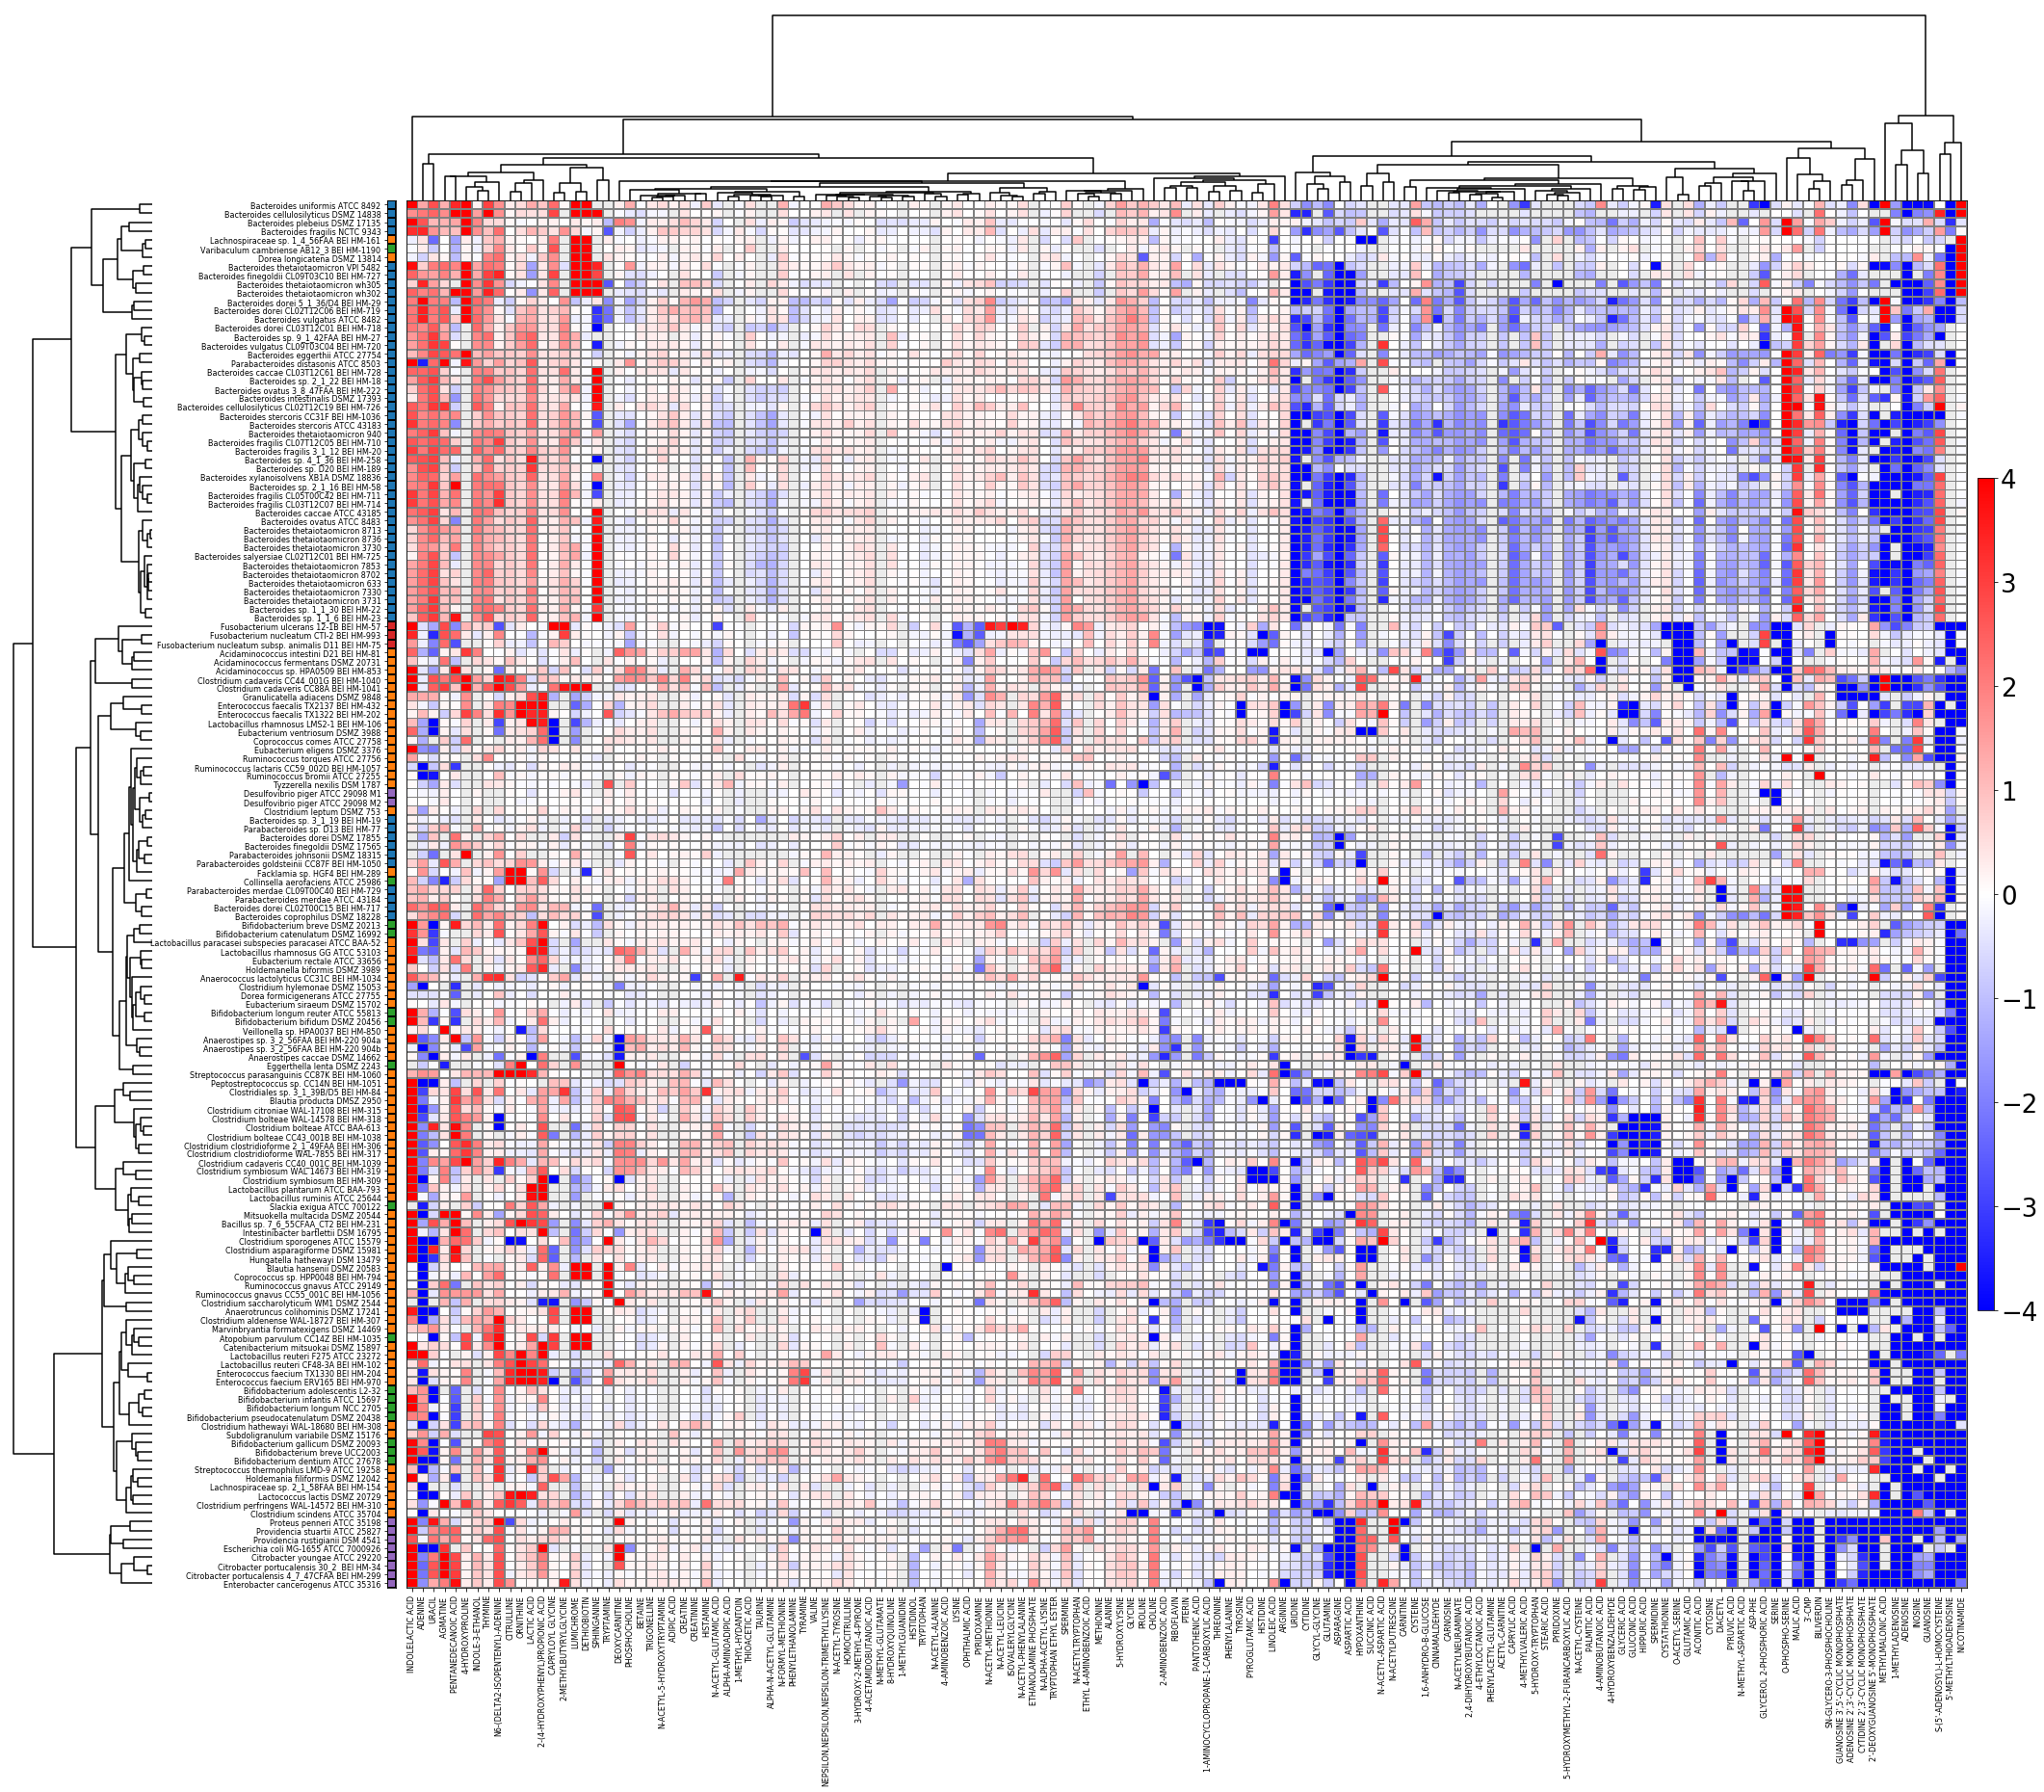

In [15]:
fig = heatmap.plot()

## Construct scatter plots as a discovery tool for bacterial metabolic signatures

Scatter plots of metabolomic profiles enable visual screens for metabolic production and consumption patterns of individual metabolite(s) across 158 mega-media grown strains. Detected levels of individual metabolites in individual strains are normalized to their levels in the mega-media controls (relative fold change, log2 transformed). Each dot represents an independent biological replicate from one or more independent experiments (denoted by different dot colors), each with 3 biological replicates. Bars represent the mean + s.e.m. 

Shown in examples: 

- side-by-side metabolomic profiles of four *B. fragilis* strains of the same species, with uniquely detected (non-coeluting) metabolites displayed in the order as appeared in the heatmaps.

- side-by-side metabolomic profiles of four *B. fragilis* strains of the same species, with all detected metabolites (uniquely detected and coeluting) displayed in an alphabetical order.

- metabolic production and consumption patterns for two individual metabolites, tyramine and pantothenic acid, across all 158 mega-media grown strains. 


In [16]:
class ScatterPlot:
    
    def __init__(self, 
                 fc_matrix):
        self.fc_matrix = fc_matrix
    
    
    def plot_taxonomies(self, taxonomies, medias, xaxis_values = None):
        data = self._get_taxonomy_data(taxonomies, medias, xaxis_values)
        return self._plot_data(data, 'taxonomies')
    
    
    def plot_metabolites(self, metabolites, medias, xaxis_values = None):
        data = self._get_metabolite_data(metabolites, medias, xaxis_values)
        return self._plot_data(data, 'metabolites')


    def _plot_data(self, data, data_type='taxonomies'):
        fig, axs = plt.subplots(len(data),
                                1,
                                figsize=(80, 8 * len(data) + 14),
                                sharex=True,
                                sharey=True,
                                squeeze=False)

        fig.subplots_adjust(left=0.05, right= 0.95, top=0.95, bottom=0.4, hspace=0.1)

        for idx, plot_data in enumerate(data):
            ax = axs[idx, 0]
            ax.set_title(plot_data['name'], {'fontsize': 30}, loc='left')

            x = plot_data['x']
            y = plot_data['y']

            ax.scatter(x, y, c=plot_data['colors'], s=20, alpha=0.5)
            ax.errorbar(plot_data['error_bars']['x'],
                        plot_data['error_bars']['means'],
                        yerr=plot_data['error_bars']['errors'],
                        fmt='_',
                        capsize=4,
                        color='black',
                        elinewidth=1)

            ax.tick_params(axis='x', rotation=90, labelsize=15)
            ax.set_xticks(list(range(0, len(plot_data['x_labels']))))
            ax.set_xticklabels(plot_data['x_labels'])

            ax.tick_params(axis='y', labelsize=20)
            ax.margins(x=0.003)

        fig.text(0.5, 0.07, 'Taxonomy' if data_type == 'metabolites' else 'Metabolite',
                 ha='center',
                 va='center',
                 fontdict={'fontsize': 30})

        fig.text(0.02, 0.5, 'Relative fold change vs. media blank control (log2)',
                 ha='center',
                 va='center',
                 rotation=90,
                 fontdict={'fontsize': 30})
        
        return fig


    def _get_taxonomy_data(self, taxonomies, medias, xaxis_values = None):
        """
        Calculate scatter plot data for taxonomies, including means and errors for error bars
        """
        
        x_values = set()

        if xaxis_values is not None:
            x_values = xaxis_values
        else:
            # Get a list of all metabolites in alphabetical order
            for taxonomy in taxonomies:
                for media in medias:
                    filtered_matrix = self.fc_matrix[(self.fc_matrix['taxonomy'] == taxonomy) & (self.fc_matrix['media'] == media)]

                    for idx, row in filtered_matrix.iterrows():
                        for metabolite_col in filtered_matrix.columns:
                            if metabolite_col in ['experiment', 'media', 'taxonomy', 'sample_type']:
                                continue

                            value = row[metabolite_col]

                            if isinstance(value, pd.Series):
                                print("Duplicate columns detected")
                                print(value)
                                continue

                            if pd.isna(value):
                                continue

                            x_values.add(metabolite_col)

            x_values = sorted(list(x_values))
                
        x_value_indices = {value:key for key, value in enumerate(x_values)}

        data = []
        colors = ['tab:blue', 'tab:red', 'tab:orange']

        for taxonomy in taxonomies:
            for media in medias:
                filtered_matrix = self.fc_matrix[(self.fc_matrix['taxonomy'] == taxonomy) & (self.fc_matrix['media'] == media)]

                exps_by_x_value = defaultdict(set)
                y_values_by_x_value = defaultdict(list)

                taxonomy_data = {
                    'name': "{} ({})".format(taxonomy, media),
                    'x': [],
                    'y': [],
                    'x_labels': x_values,
                    'colors': [],
                    'error_bars': {
                        'x': [],
                        'means': [],
                        'errors': []
                    }
                }

                for idx, row in filtered_matrix.iterrows():
                    experiment = row['experiment']

                    for metabolite_col in filtered_matrix.columns:
                        if metabolite_col in ['experiment', 'media', 'taxonomy', 'sample_type']:
                            continue

                        value = row[metabolite_col]

                        if isinstance(value, pd.Series) or pd.isna(value):
                            continue

                        if metabolite_col not in x_value_indices:
                            continue

                        x_value = x_value_indices[metabolite_col]

                        exps_by_x_value[x_value].add(experiment)
                        y_values_by_x_value[x_value].append(value)

                        taxonomy_data['x'].append(x_value)
                        taxonomy_data['y'].append(value)
                        taxonomy_data['colors'].append(colors[len(exps_by_x_value[x_value]) - 1])

                for x, y_values in y_values_by_x_value.items():
                    taxonomy_data['error_bars']['x'].append(x)
                    taxonomy_data['error_bars']['means'].append(np.mean(y_values))
                    taxonomy_data['error_bars']['errors'].append(stats.sem(y_values))

                data.append(taxonomy_data)

        return data
    
    
    def _get_metabolite_data(self, metabolites, medias, xaxis_values = None):
        """
        Calculate scatter plot data for metabolites, including means and errors for error bars
        """
        
        x_values = set()
        
        if xaxis_values:
            x_values = xaxis_values
        else:
            # Get a list of all taxonomies in alphabetical order
            for metabolite in metabolites:
                metabolite_cols = list(filter(lambda col: col.startswith(metabolite), self.fc_matrix.columns))
                print("Columns found for {}: ".format(metabolite) + str(metabolite_cols))

                for media in medias:
                    filtered_matrix = self.fc_matrix[self.fc_matrix['media'] == media] \
                        .sort_values(by=['taxonomy'])

                    for idx, row in filtered_matrix.iterrows():
                        taxonomy = row['taxonomy']
                        
                        for metabolite_col in metabolite_cols:
                            value = row[metabolite_col]

                            if pd.isna(value):
                                continue

                            x_values.add(taxonomy)

            x_values = sorted(list(x_values))
        
        x_value_indices = {value:key for key, value in enumerate(x_values)}

        data = []
        colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink']

        for metabolite in metabolites:
            metabolite_cols = list(filter(lambda col: col.startswith(metabolite), self.fc_matrix.columns))

            for media in medias:
                filtered_matrix = self.fc_matrix[self.fc_matrix['media'] == media] \
                    .sort_values(by=['taxonomy'])

                exps_by_x_value = defaultdict(set)
                y_values_by_x_value = defaultdict(list)

                metabolite_data = {
                    'name': "{} ({})".format(metabolite, media),
                    'x': [],
                    'y': [],
                    'x_labels': x_values,
                    'colors': [],
                    'error_bars': {
                        'x': [],
                        'means': [],
                        'errors': []
                    }
                }

                for idx, row in filtered_matrix.iterrows():
                    taxonomy = row['taxonomy']
                    experiment = row['experiment']

                    for metabolite_col in metabolite_cols:
                        value = row[metabolite_col]

                        if pd.isna(value):
                            continue

                        x_label = taxonomy

                        if x_label not in x_value_indices:
                            continue

                        x_value = x_value_indices[x_label]

                        exps_by_x_value[x_value].add(experiment)
                        y_values_by_x_value[x_value].append(value)

                        metabolite_data['x'].append(x_value)
                        metabolite_data['y'].append(value)
                        metabolite_data['colors'].append(colors[len(exps_by_x_value[x_value]) - 1])

                for x, y_values in y_values_by_x_value.items():
                    metabolite_data['error_bars']['x'].append(x)
                    metabolite_data['error_bars']['means'].append(np.mean(y_values))
                    metabolite_data['error_bars']['errors'].append(stats.sem(y_values))

                data.append(metabolite_data)

        return data
        

### Scatter plot example: side-by-side metabolomic profiles of four *B. fragilis* strains of the same species, with a list of uniquely detected (non-coeluting) metabolites displayed in the same way as appeared in the heatmaps.


In [17]:
fc_matrix = pd.read_excel('input/Supplementary_Table_7.xlsx', sheet_name='foldchange.fa.ps_log2', index_col=0)

# Co-eluting compounds (sharing the same dnames) are concatenated together by their compound names
dname_cpd_map = cpd_library \
    .groupby(['dname'])['Compound'] \
    .apply(lambda compounds: ', '.join(sorted(set(compounds)))) \
    .to_dict()

# Remove internal standard columns so they are not displayed as a part the heatmap
fc_matrix = fc_matrix.drop(columns=get_internal_standards_columns(fc_matrix, dname_cpd_map))

# Pull in data from aggregated_md so we get metadata information for each biological replicate
fc_matrix = fc_matrix.join(aggregated_md[['experiment', 'sample_type', 'media', 'taxonomy']], how="left")

fc_matrix = fc_matrix[fc_matrix['sample_type'] == 'supernatant']
fc_matrix = fc_matrix.rename(columns=dname_cpd_map)

scatter_plot = ScatterPlot(fc_matrix)

### Scatter plot example: side-by-side metabolomic profiles of four *B. fragilis* strains of the same species, with a list of all detected metabolites displayed in the alphabetic order. 


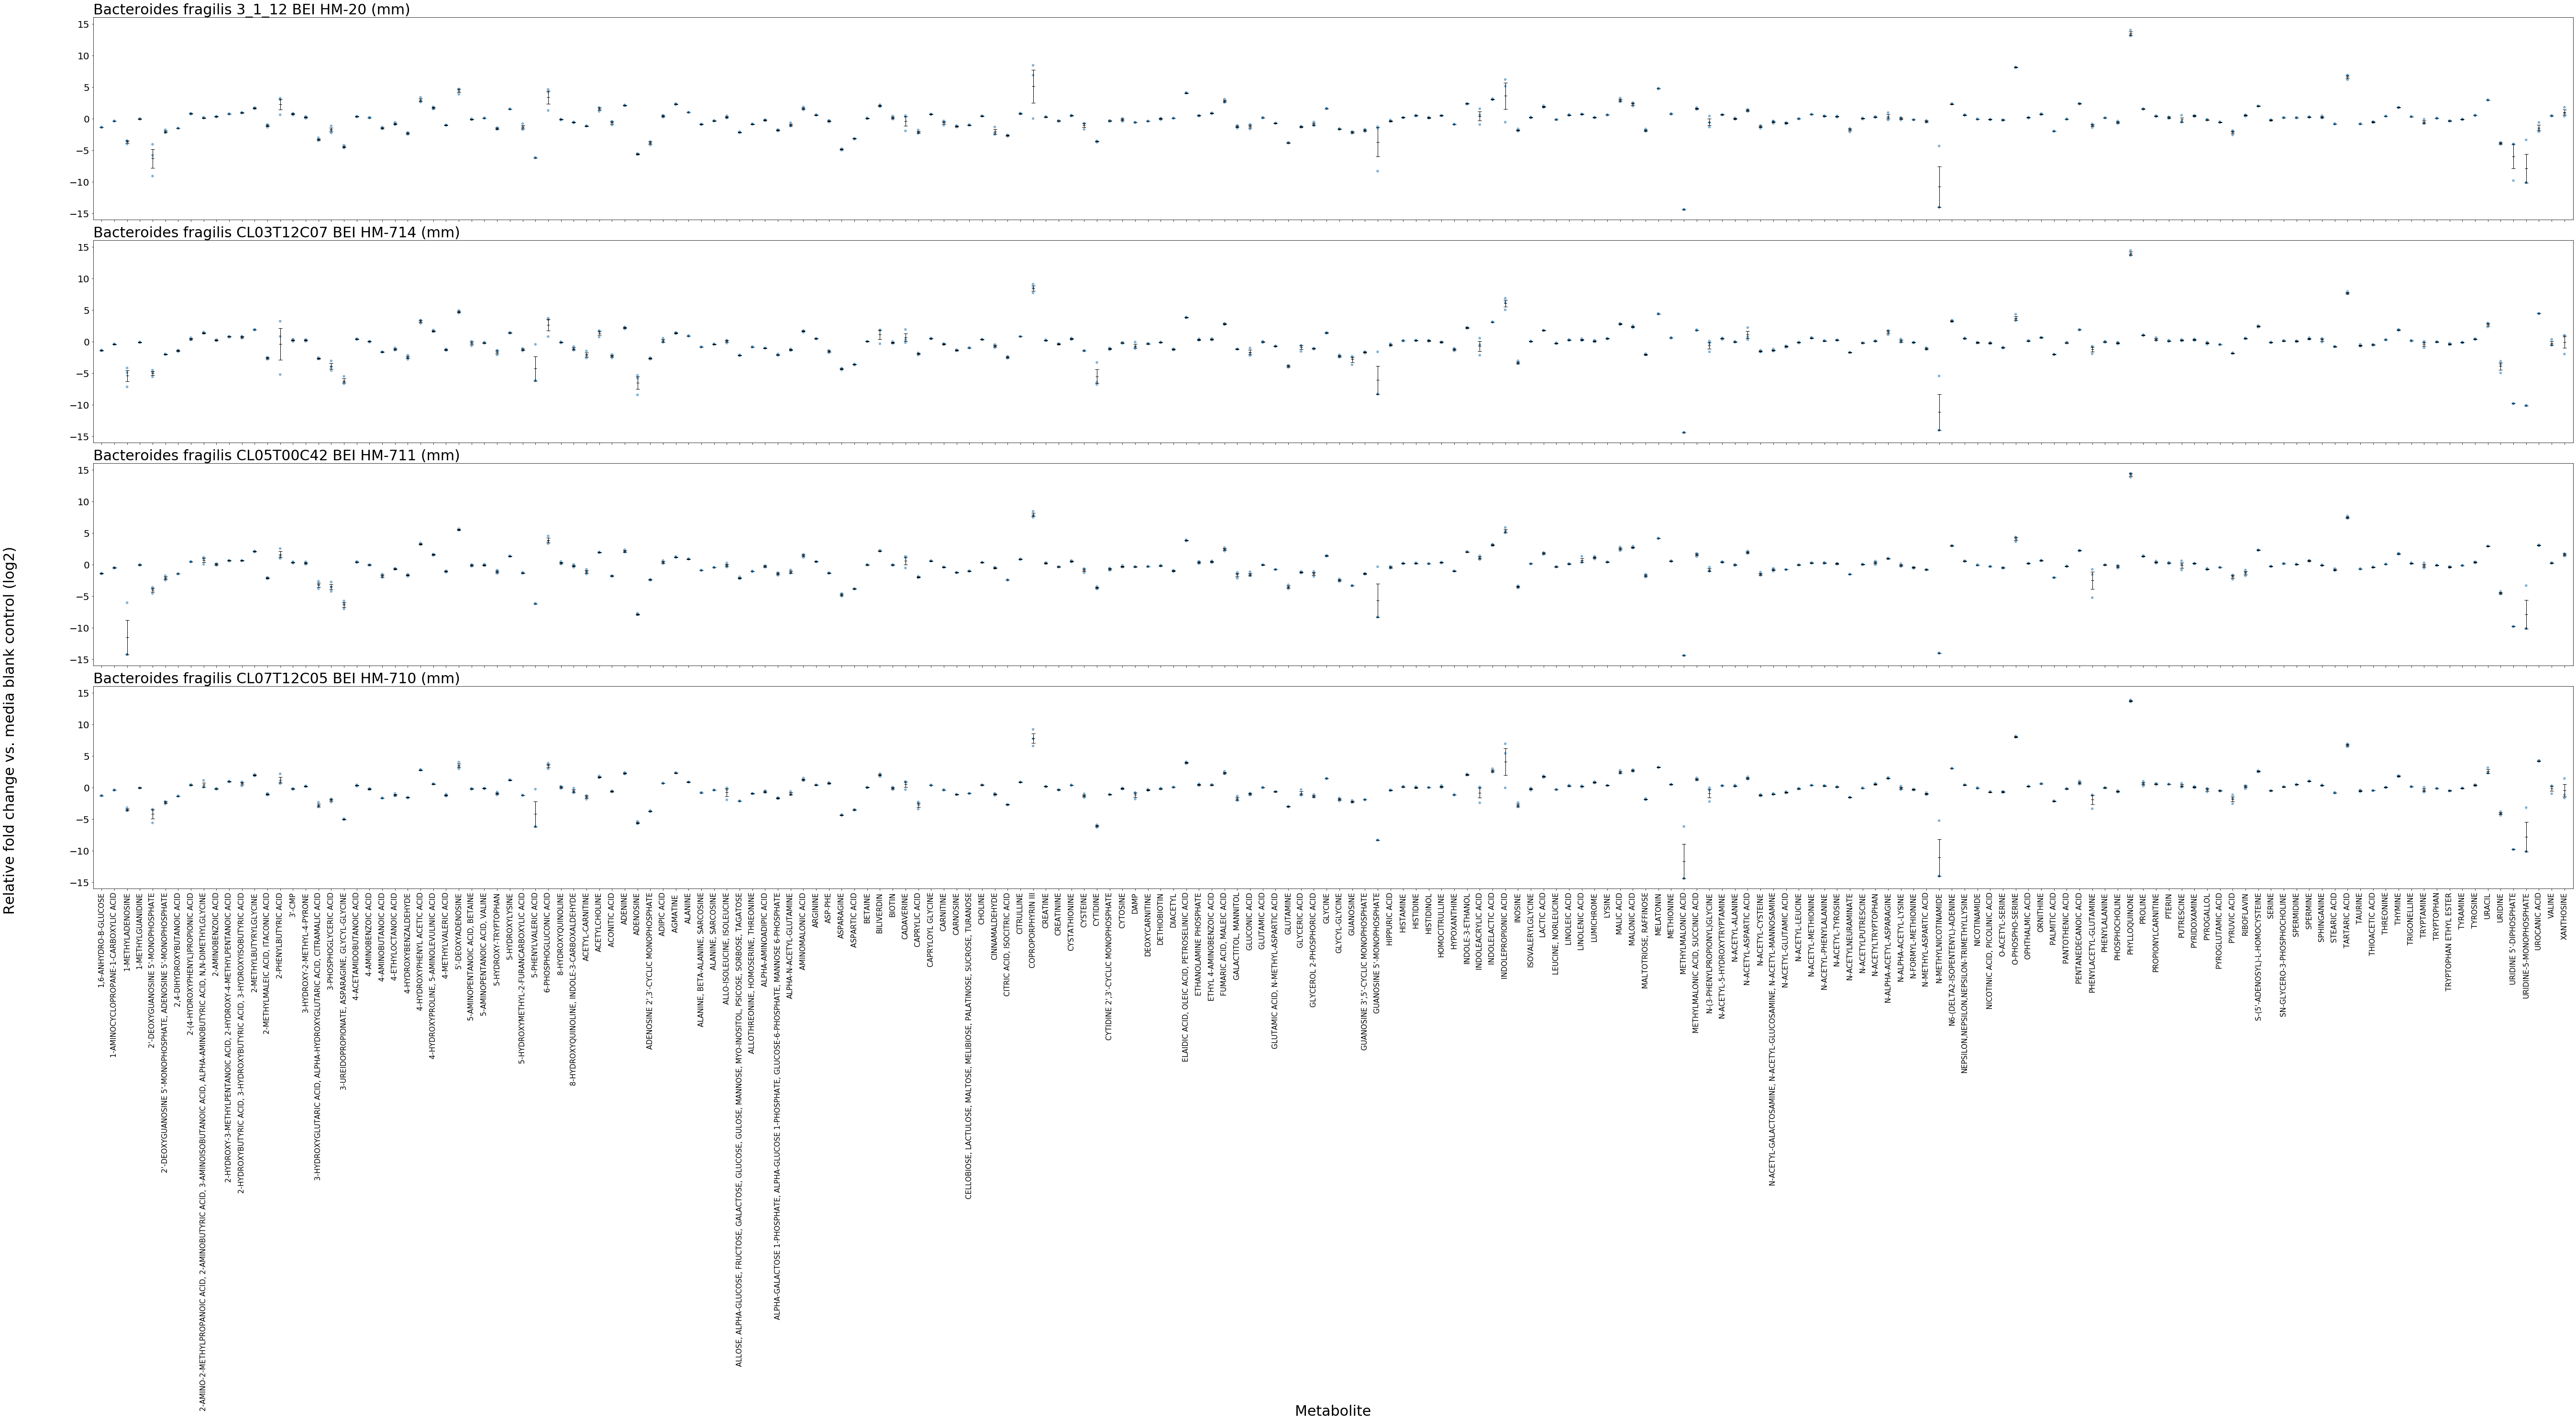

In [19]:
fig = scatter_plot.plot_taxonomies(
    [
        'Bacteroides fragilis 3_1_12 BEI HM-20',
        'Bacteroides fragilis CL03T12C07 BEI HM-714',
        'Bacteroides fragilis CL05T00C42 BEI HM-711',
        'Bacteroides fragilis CL07T12C05 BEI HM-710'
    ],
    ['mm'] #mm is an abbreivation for "mega media"
)

### Scatter plot example: metabolic production and consumption patterns for two individual metabolites, tyramine and pantothenic acid, across all 158 mega-media grown strains. 


Columns found for TYRAMINE: ['TYRAMINE']
Columns found for PANTOTHENIC ACID: ['PANTOTHENIC ACID']


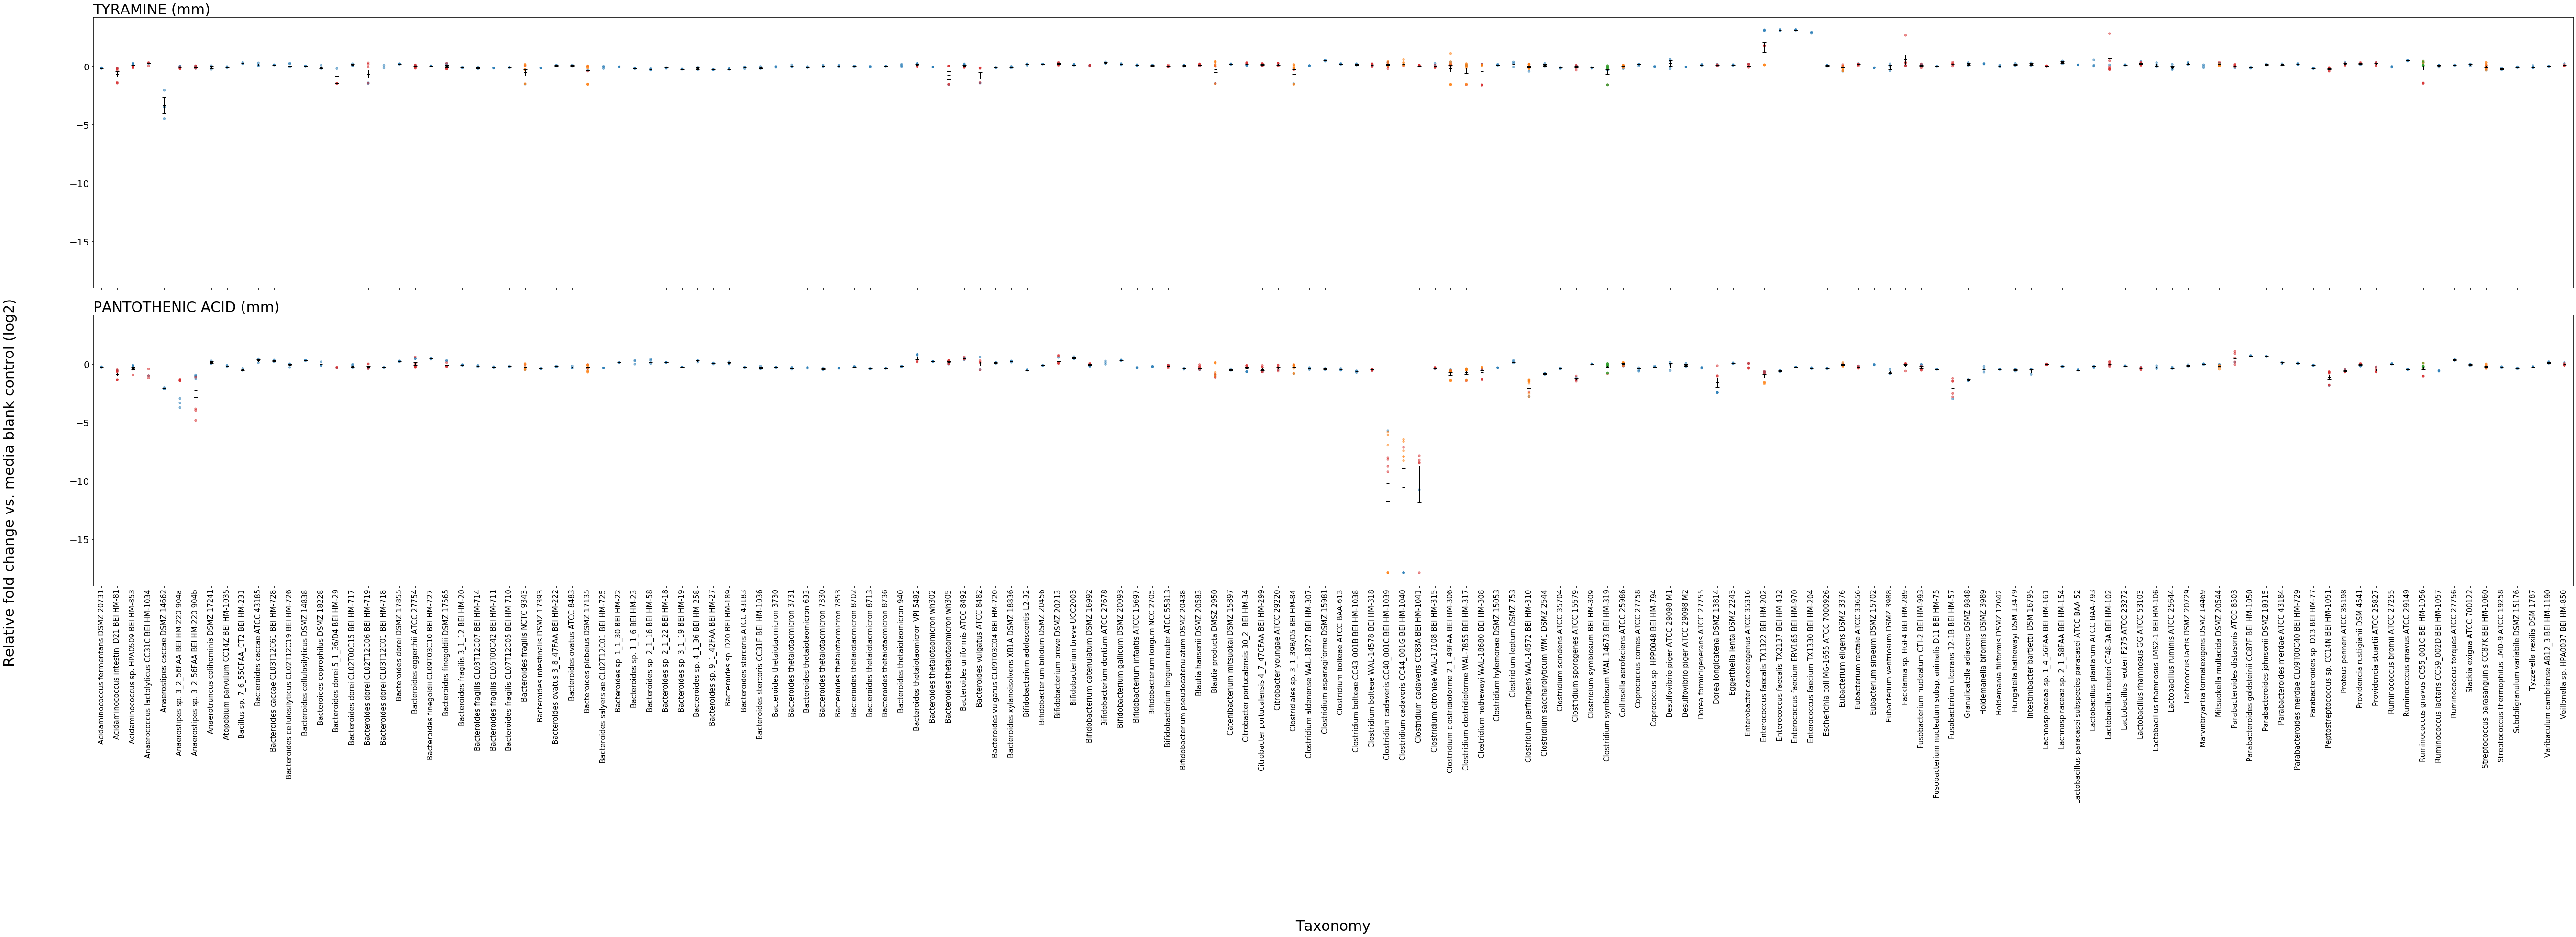

In [20]:
fig = scatter_plot.plot_metabolites(
    ['TYRAMINE', 'PANTOTHENIC ACID'], 
    ['mm'], #mm is an abbreivation for "mega media"
)